In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import callbacks

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
from data_loading import OxfordPetDataset
from augmentation import random_flip, augmentation_layers_geometric, augmentation_layers_color
from models import UNet_model #2.a, 2.b exercises
from experiment import plot_results

from collections import Counter



# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
#dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (128, 128)
dataset.res_norm(reshape_size)

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")

# for i, example in enumerate(train.take(2)):  # Take two examples
#     print(f"Example {i+1} - Image shape:", example['image'].shape)
#     image = example['image']
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, i+1)
#     plt.imshow(image)
#     #label = example['label']
#     #print(f"Example {i+1} - Label = ", label.numpy())
#     mask = example['segmentation_mask']  # This is the segmentation mask
#     plt.imshow(mask, cmap='gray', alpha=0.5)
#     print(f"Example {i+1} - Mask shape:", mask.numpy().shape)
#     print("\n")
# plt.show()

Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669




In [5]:
augmentation_color = augmentation_layers_color()
augmentation_geometric = augmentation_layers_geometric()

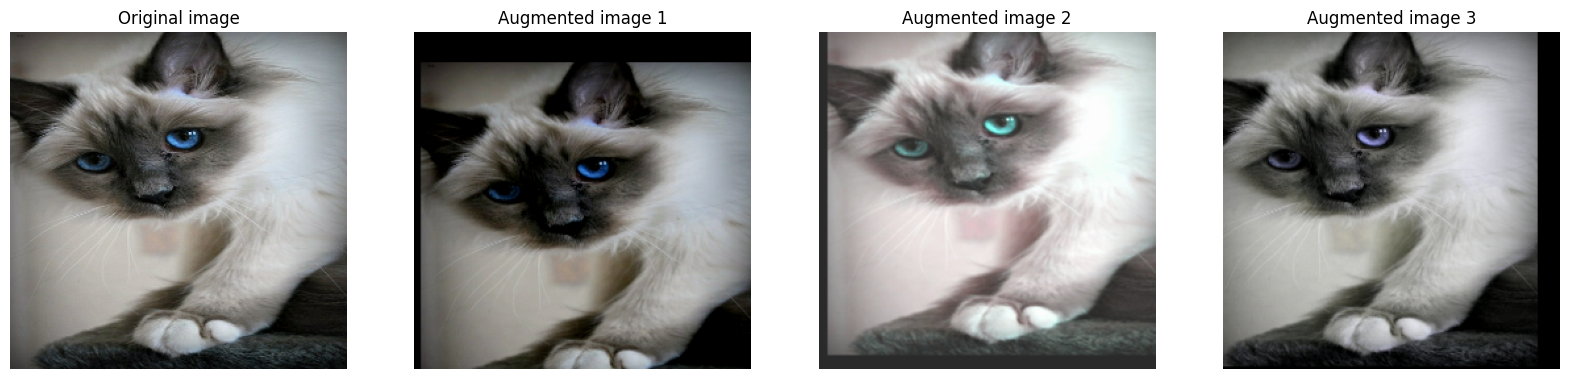

In [6]:
for example in train.take(1):
    image = example['image']
    
    plt.figure(figsize=(20, 5))
    
    # Plot original image
    plt.subplot(1, 4, 1)
    plt.title("Original image")
    plt.imshow(image)
    plt.axis("off")
    
    # Plot augmented images
    for i in range(3):
        aug_img = augmentation_geometric(tf.expand_dims(image, axis=0))
        aug_img = augmentation_color(aug_img)
        plt.subplot(1, 4, i+2)
        plt.title(f"Augmented image {i+1}")
        plt.imshow(aug_img[0])
        plt.axis("off")

plt.show()

From now on we want all datasets to be lists of just images and masks

In [4]:
def extract_image_mask(data):
    """Extract image and mask from dictionary"""
    return data['image'], data['segmentation_mask']

# Apply to all datasets
train = train.map(extract_image_mask)
val = val.map(extract_image_mask)
test = test.map(extract_image_mask)

In [7]:
def augment_image_mask(image, mask):
    # Add a batch dimension to the image and mask for the augmentation layers
    batched_image = tf.expand_dims(image, axis=0)
    batched_mask = tf.expand_dims(mask, axis=0)
    
    # Cast the mask to float32 to match the image's data type after augmentation
    batched_mask = tf.cast(batched_mask, tf.float32)
    
    # Apply color-based augmentations to the image only
    aug_image = augmentation_color(batched_image, training=True)
    
    # Concatenate the augmented image and mask to apply geometric augmentations
    combined = tf.concat([aug_image, batched_mask], axis=-1)
    
    # Apply geometric augmentations to both image and mask
    combined = augmentation_geometric(combined, training=True)
    
    # Split the concatenated tensor back into image and mask
    aug_image, aug_mask = tf.split(combined, [3, tf.shape(batched_mask)[-1]], axis=-1)
    
    # Remove the batch dimension and cast the mask back to uint8 if necessary
    aug_image = tf.squeeze(aug_image, axis=0)
    aug_mask = tf.squeeze(aug_mask, axis=0)
    aug_mask = tf.cast(aug_mask, tf.uint8)  # Cast back to original type if needed
    
    return aug_image, aug_mask

In [5]:
BATCH_SIZE = 32

# Assume `raw_train` is your unaugmented dataset
cached_train = train.cache()  # Cache the raw images & masks

# Batch the data and use prefetching to optimize loading speed
# Apply augmentation dynamically during training, only on the training dataset
# train_ds = cached_train.map(
#     augment_image_mask, 
#     num_parallel_calls=tf.data.AUTOTUNE
# ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds = train.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
from metrics import iou_metric, dice_coefficient
import os
# Initialize and compile model
top_dir = "task_2a"
best_model_folder = os.path.join(top_dir, "Unet_best_baseline_model")
model = UNet_model(input_shape=reshape_size + (3,))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', iou_metric, dice_coefficient])

# Define callback to save the best model
checkpoint = ModelCheckpoint(
    best_model_folder,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

In [8]:
# Train the model
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
104/104 [==============================] - ETA: 0s - loss: 0.9419 - accuracy: 0.5776 - iou_metric: 0.5826 - dice_coefficient: 0.5780   
Epoch 1: val_loss improved from inf to 0.83745, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 84s 505ms/step - loss: 0.9419 - accuracy: 0.5776 - iou_metric: 0.5826 - dice_coefficient: 0.5780 - val_loss: 0.8374 - val_accuracy: 0.5926 - val_iou_metric: 0.5910 - val_dice_coefficient: 0.5910
Epoch 2/100
104/104 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.7065 - iou_metric: 0.8686 - dice_coefficient: 0.7067 
Epoch 2: val_loss improved from 0.83745 to 0.66386, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 44s 426ms/step - loss: 0.7029 - accuracy: 0.7065 - iou_metric: 0.8686 - dice_coefficient: 0.7067 - val_loss: 0.6639 - val_accuracy: 0.7280 - val_iou_metric: 0.8796 - val_dice_coefficient: 0.7269
Epoch 3/100
104/104 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.7306 - iou_metric: 0.9134 - dice_coefficient: 0.7305  
Epoch 3: val_loss improved from 0.66386 to 0.63230, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 44s 423ms/step - loss: 0.6564 - accuracy: 0.7306 - iou_metric: 0.9134 - dice_coefficient: 0.7305 - val_loss: 0.6323 - val_accuracy: 0.7412 - val_iou_metric: 0.9066 - val_dice_coefficient: 0.7400
Epoch 4/100
104/104 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7405 - iou_metric: 0.9350 - dice_coefficient: 0.7404  
Epoch 4: val_loss did not improve from 0.63230
104/104 [==============================] - 30s 285ms/step - loss: 0.6357 - accuracy: 0.7405 - iou_metric: 0.9350 - dice_coefficient: 0.7404 - val_loss: 0.6327 - val_accuracy: 0.7355 - val_iou_metric: 0.8835 - val_dice_coefficient: 0.7342
Epoch 5/100
104/104 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.7581 - iou_metric: 0.9696 - dice_coefficient: 0.7585 
Epoch 5: val_loss did not improve from 0.63230
104/104 [==============================] - 30s 286ms/step - loss: 0.5969 - accuracy: 0.7581 - iou_metric: 0.9696 - dice_coefficient: 0.75

INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 44s 426ms/step - loss: 0.5147 - accuracy: 0.7984 - iou_metric: 1.0463 - dice_coefficient: 0.7985 - val_loss: 0.5824 - val_accuracy: 0.7759 - val_iou_metric: 0.9375 - val_dice_coefficient: 0.7752
Epoch 7/100
104/104 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.8213 - iou_metric: 1.0908 - dice_coefficient: 0.8214  
Epoch 7: val_loss improved from 0.58238 to 0.47606, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 45s 426ms/step - loss: 0.4631 - accuracy: 0.8213 - iou_metric: 1.0908 - dice_coefficient: 0.8214 - val_loss: 0.4761 - val_accuracy: 0.8152 - val_iou_metric: 1.0354 - val_dice_coefficient: 0.8148
Epoch 8/100
104/104 [==============================] - ETA: 0s - loss: 0.4176 - accuracy: 0.8391 - iou_metric: 1.1254 - dice_coefficient: 0.8391 
Epoch 8: val_loss improved from 0.47606 to 0.43254, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 40s 379ms/step - loss: 0.4176 - accuracy: 0.8391 - iou_metric: 1.1254 - dice_coefficient: 0.8391 - val_loss: 0.4325 - val_accuracy: 0.8292 - val_iou_metric: 1.0618 - val_dice_coefficient: 0.8291
Epoch 9/100
104/104 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8407 - iou_metric: 1.1267 - dice_coefficient: 0.8407  
Epoch 9: val_loss improved from 0.43254 to 0.40315, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 46s 440ms/step - loss: 0.4131 - accuracy: 0.8407 - iou_metric: 1.1267 - dice_coefficient: 0.8407 - val_loss: 0.4031 - val_accuracy: 0.8450 - val_iou_metric: 1.1113 - val_dice_coefficient: 0.8443
Epoch 10/100
104/104 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8589 - iou_metric: 1.1628 - dice_coefficient: 0.8591  
Epoch 10: val_loss improved from 0.40315 to 0.36570, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 46s 439ms/step - loss: 0.3670 - accuracy: 0.8589 - iou_metric: 1.1628 - dice_coefficient: 0.8591 - val_loss: 0.3657 - val_accuracy: 0.8594 - val_iou_metric: 1.1577 - val_dice_coefficient: 0.8588
Epoch 11/100
104/104 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.8675 - iou_metric: 1.1803 - dice_coefficient: 0.8676  
Epoch 11: val_loss improved from 0.36570 to 0.36152, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 47s 451ms/step - loss: 0.3464 - accuracy: 0.8675 - iou_metric: 1.1803 - dice_coefficient: 0.8676 - val_loss: 0.3615 - val_accuracy: 0.8601 - val_iou_metric: 1.1730 - val_dice_coefficient: 0.8596
Epoch 12/100
104/104 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8707 - iou_metric: 1.1882 - dice_coefficient: 0.8709  
Epoch 12: val_loss improved from 0.36152 to 0.35143, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 45s 426ms/step - loss: 0.3369 - accuracy: 0.8707 - iou_metric: 1.1882 - dice_coefficient: 0.8709 - val_loss: 0.3514 - val_accuracy: 0.8628 - val_iou_metric: 1.1752 - val_dice_coefficient: 0.8622
Epoch 13/100
104/104 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8758 - iou_metric: 1.1975 - dice_coefficient: 0.8760  
Epoch 13: val_loss improved from 0.35143 to 0.34172, saving model to task_2a\Unet_best_baseline_model


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


INFO:tensorflow:Assets written to: task_2a\Unet_best_baseline_model\assets


104/104 [==============================] - 46s 436ms/step - loss: 0.3238 - accuracy: 0.8758 - iou_metric: 1.1975 - dice_coefficient: 0.8760 - val_loss: 0.3417 - val_accuracy: 0.8699 - val_iou_metric: 1.1690 - val_dice_coefficient: 0.8694
Epoch 14/100
104/104 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8845 - iou_metric: 1.2148 - dice_coefficient: 0.8846  
Epoch 14: val_loss did not improve from 0.34172
104/104 [==============================] - 30s 284ms/step - loss: 0.3018 - accuracy: 0.8845 - iou_metric: 1.2148 - dice_coefficient: 0.8846 - val_loss: 0.3477 - val_accuracy: 0.8682 - val_iou_metric: 1.1918 - val_dice_coefficient: 0.8671
Epoch 15/100
104/104 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8875 - iou_metric: 1.2207 - dice_coefficient: 0.8877 
Epoch 15: val_loss did not improve from 0.34172
104/104 [==============================] - 30s 283ms/step - loss: 0.2931 - accuracy: 0.8875 - iou_metric: 1.2207 - dice_coefficient: 

In [ ]:
# # Load the best model
# best_model = tf.keras.models.load_model(best_model_folder, custom_objects={
#     'iou_metric': iou_metric,
#     'dice_coefficient': dice_coefficient
# })

# # Evaluate on validation set (optional but confirms performance)
# val_loss, val_accuracy, val_iou, val_dice, val_pixel_accuracy = best_model.evaluate(val_ds)
# print(f"\nBest Model Validation Metrics:")
# print(f"Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
# print(f"IoU: {val_iou:.4f}, Dice Coefficient: {val_dice:.4f}, Pixel Accuracy: {val_pixel_accuracy:.4f}")

# # Evaluate on test set
# test_loss, test_accuracy, test_iou, test_dice, test_pixel_accuracy = best_model.evaluate(test_ds)
# print(f"\nBest Model Test Metrics:")
# print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
# print(f"IoU: {test_iou:.4f}, Dice Coefficient: {test_dice:.4f}, Pixel Accuracy: {test_pixel_accuracy:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.0000e+00 - loss: 0.0564

Best Model Validation Metrics:
Loss: 0.0579, Accuracy: 0.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.0000e+00 - loss: 0.0566

Best Model Test Metrics:
Loss: 0.0552, Accuracy: 0.0000


In [9]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Create the results folder
top_dir = "task_2a"
results_folder = os.path.join(top_dir,"unet_baseline_model_results")
os.makedirs(results_folder, exist_ok=True)

# Load the best model
best_model = tf.keras.models.load_model(
    best_model_folder, 
    custom_objects={
        'iou_metric': iou_metric,
        'dice_coefficient': dice_coefficient
    }
)

# Evaluate on validation set
val_metrics = best_model.evaluate(val_ds, return_dict=True)
val_loss = val_metrics['loss']
val_accuracy = val_metrics['accuracy']
val_iou = val_metrics['iou_metric']
val_dice = val_metrics['dice_coefficient']
val_pixel_accuracy = val_metrics.get('pixel_accuracy', np.nan)

# Evaluate on test set
test_metrics = best_model.evaluate(test_ds, return_dict=True)
test_loss = test_metrics['loss']
test_accuracy = test_metrics['accuracy']
test_iou = test_metrics['iou_metric']
test_dice = test_metrics['dice_coefficient']
test_pixel_accuracy = test_metrics.get('pixel_accuracy', np.nan)

# Save test results in a separate CSV file
test_results = {
    "Loss": [test_loss],
    "Accuracy": [test_accuracy],
    "IoU": [test_iou],
    "Dice Coefficient": [test_dice],
    "Pixel Accuracy": [test_pixel_accuracy]
}
test_results_df = pd.DataFrame(test_results)
test_csv_path = os.path.join(results_folder, "test_metrics.csv")
test_results_df.to_csv(test_csv_path, index=False)
print(f"Test metrics saved to {test_csv_path}")

# Plot training curves and save training history if available.
# Note: The history is assumed to be stored in a variable called 'history'
# that was previously obtained from model.fit().
if 'history' in globals():
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    loss_plot_path = os.path.join(results_folder, "loss_plot.png")
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot saved to {loss_plot_path}")

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    accuracy_plot_path = os.path.join(results_folder, "accuracy_plot.png")
    plt.savefig(accuracy_plot_path)
    plt.close()
    print(f"Accuracy plot saved to {accuracy_plot_path}")

    # Plot training and validation IoU
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['iou_metric'], label='Training IoU')
    plt.plot(history.history['val_iou_metric'], label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    iou_plot_path = os.path.join(results_folder, "iou_plot.png")
    plt.savefig(iou_plot_path)
    plt.close()
    print(f"IoU plot saved to {iou_plot_path}")

    # Plot training and validation Dice Coefficient
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    dice_plot_path = os.path.join(results_folder, "dice_plot.png")
    plt.savefig(dice_plot_path)
    plt.close()
    print(f"Dice Coefficient plot saved to {dice_plot_path}")

    # Save the training history (training and validation metrics) to a CSV file
    history_df = pd.DataFrame(history.history)
    history_csv_path = os.path.join(results_folder, "training_history.csv")
    history_df.to_csv(history_csv_path, index=False)
    print(f"Training history saved to {history_csv_path}")
else:
    print("Training history is not available as 'history' variable.")

# Print evaluation results
print("\nBest Model Validation Metrics:")
print(f"Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
print(f"IoU: {val_iou:.4f}, Dice Coefficient: {val_dice:.4f}, Pixel Accuracy: {val_pixel_accuracy:.4f}")

print("\nBest Model Test Metrics:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
print(f"IoU: {test_iou:.4f}, Dice Coefficient: {test_dice:.4f}, Pixel Accuracy: {test_pixel_accuracy:.4f}")


115/115 [==============================] - 15s 128ms/step - loss: 0.3637 - accuracy: 0.8610 - iou_metric: 1.1603 - dice_coefficient: 0.8610
Test metrics saved to task_2a\unet_baseline_model_results\test_metrics.csv
Loss plot saved to task_2a\unet_baseline_model_results\loss_plot.png
Accuracy plot saved to task_2a\unet_baseline_model_results\accuracy_plot.png
IoU plot saved to task_2a\unet_baseline_model_results\iou_plot.png
Dice Coefficient plot saved to task_2a\unet_baseline_model_results\dice_plot.png
Training history saved to task_2a\unet_baseline_model_results\training_history.csv

Best Model Validation Metrics:
Loss: 0.3417, Accuracy: 0.8699
IoU: 1.1690, Dice Coefficient: 0.8694, Pixel Accuracy: nan

Best Model Test Metrics:
Loss: 0.3637, Accuracy: 0.8610
IoU: 1.1603, Dice Coefficient: 0.8610, Pixel Accuracy: nan
